# Investigating the vanishing feature phenomenon in merged/pruned models

This notebook contains the implementation of investigating the vanishing feature phenomenon in merged and pruned networks reported in Sections 4.1 and 4.5 of our paper.

In [1]:
import sys
sys.path.append('..')

In [2]:
from source.utils.utils import load_model
from source.utils.connect import interpolate_state_dicts, reset_bn_stats
from source.utils.data_funcs import load_data
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from source.utils.train import validate
import numpy as np
from copy import deepcopy
from source.utils.logger import Logger
import matplotlib.pyplot as plt
import os


def record_activations(model, loader, mean_metric, act_metric, pre_relu=False):
    model.eval()  # use eval mode to simulate inference
    device = next(model.parameters()).device
    zero_input = torch.zeros((1, 3, 32, 32)).to(next(model.parameters()).device)  # zero input for calculating f^l(0)
    hooks = []
    activation_dict = {}
    zero_activation_dict = {}
    is_zero_pass = False  # Flag to determine if processing zero input

    # Hook function to store activations; store pre-activation values if pre_act=True
    def hook_fn(module, input, output, name, pre_act):
        saved_value = input[0] if pre_act else output
        if is_zero_pass:
            zero_activation_dict[name] = saved_value.detach().clone()
        else:
            activation_dict[name] = saved_value.detach().clone()

    # Register hooks for layers of interest
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear, nn.BatchNorm2d, nn.LayerNorm)):
            hooks.append(module.register_forward_hook(lambda m, i, o, n=name: hook_fn(m, i, o, n, False)))

    # Pass through zero input to compute f^l(0)
    print("Calculating activations for zero input")
    is_zero_pass = True  # Enable zero input pass
    with torch.no_grad():
        model(zero_input)
    is_zero_pass = False  # Reset flag after zero input pass
 
    # First pass: calculate means
    print("Calculating means")
    means_dict = {}
    num_batches = 0
    with torch.no_grad():
        for input, target in loader:
            input = input.to(device)
            model(input)
            for name in activation_dict.keys():
                if act_metric == 'diff':
                    adjusted_activation = (activation_dict[name] - zero_activation_dict[name]) # Subtract f^l(0)
                elif act_metric == 'ratio':
                    adjusted_activation = (activation_dict[name] - zero_activation_dict[name]) / (activation_dict[name]) # Divide by f^l(x)
                elif act_metric == 'total':
                    adjusted_activation = activation_dict[name]

                activation_shape = adjusted_activation.shape
                norm_dimensions = (1, 2, 3) if len(activation_shape) == 4 else (1,)
                num_dimensions =  activation_shape[1] * activation_shape[2] * activation_shape[3] if len(activation_shape) == 4 else activation_shape[1]
                if mean_metric == 'l1':
                    adjusted_activation = adjusted_activation.norm(p=1, dim=norm_dimensions)
                elif mean_metric == 'l1_mean':
                    adjusted_activation = adjusted_activation.norm(p=1, dim=norm_dimensions) / num_dimensions
                elif mean_metric == 'l2':
                    adjusted_activation = adjusted_activation.norm(p=2, dim=norm_dimensions)
                elif mean_metric == 'l2_mean':
                    adjusted_activation = adjusted_activation.norm(p=2, dim=norm_dimensions) / num_dimensions**(1/2)
                
                if name not in means_dict:
                    means_dict[name] = torch.mean(adjusted_activation, dim=0)
                else:
                    means_dict[name] += torch.mean(adjusted_activation, dim=0)
            num_batches += 1
    for name in means_dict.keys():
        means_dict[name] /= num_batches

    # Second pass: calculate stds
    print("Calculating stds")
    stds_dict = {}
    stds_dict = deepcopy(means_dict)

    # Clear hooks
    for hook in hooks:
        hook.remove()

    # Convert to numpy
    for name in means_dict:
        means_dict[name] = means_dict[name].cpu().numpy()
        stds_dict[name] = stds_dict[name].cpu().numpy()
        zero_activation_dict[name] = zero_activation_dict[name][0].cpu().numpy()
    
    return means_dict, stds_dict, zero_activation_dict

Logger.setup_logging()
logger = Logger()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## VF in merging

### Recording activations

In [10]:
model_name_s = ['cifar_vgg16', 'cifar_vgg16_bn', 'cifar_resnet20', 'cifar_resnet20_ln']
seed_s = [30, 30, 10, 10]

[2024-12-14 10:54:30] (24096) {logger.py:58}INFO - Model: cifar_vgg16
[2024-12-14 10:54:30] (24096) {logger.py:58}INFO - Seed: [30, 30, 10, 10]


Files already downloaded and verified
Files already downloaded and verified


[2024-12-14 10:54:32] (24096) {utils.py:69}INFO - Test: [ 1/40]	Time  0.035 ( 0.035)	Loss 4.4998e-01 (4.4998e-01)	Acc@1  92.19 ( 92.19)	Acc@5  99.22 ( 99.22)
[2024-12-14 10:54:33] (24096) {utils.py:74}INFO -  *   Acc@1 91.550 Acc@5 99.410


Calculating activations for zero input
Calculating means
Calculating stds
Calculating activations for zero input
Calculating means
Calculating stds
Calculating activations for zero input
Calculating means
Calculating stds


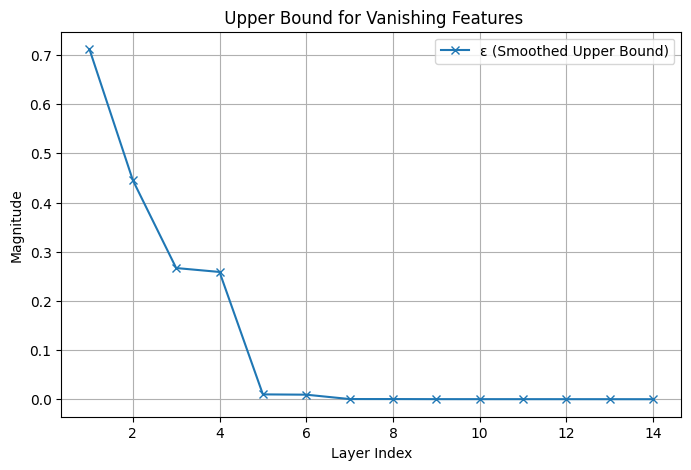

[2024-12-14 10:54:36] (24096) {logger.py:58}INFO - Model: cifar_vgg16_bn
[2024-12-14 10:54:36] (24096) {logger.py:58}INFO - Seed: [30, 30, 10, 10]


Files already downloaded and verified
Files already downloaded and verified


[2024-12-14 10:54:38] (24096) {utils.py:69}INFO - Test: [ 1/40]	Time  0.039 ( 0.039)	Loss 1.9408e-01 (1.9408e-01)	Acc@1  96.09 ( 96.09)	Acc@5  99.61 ( 99.61)
[2024-12-14 10:54:39] (24096) {utils.py:74}INFO -  *   Acc@1 93.230 Acc@5 99.700


Calculating activations for zero input
Calculating means
Calculating stds
Calculating activations for zero input
Calculating means
Calculating stds
Calculating activations for zero input
Calculating means
Calculating stds


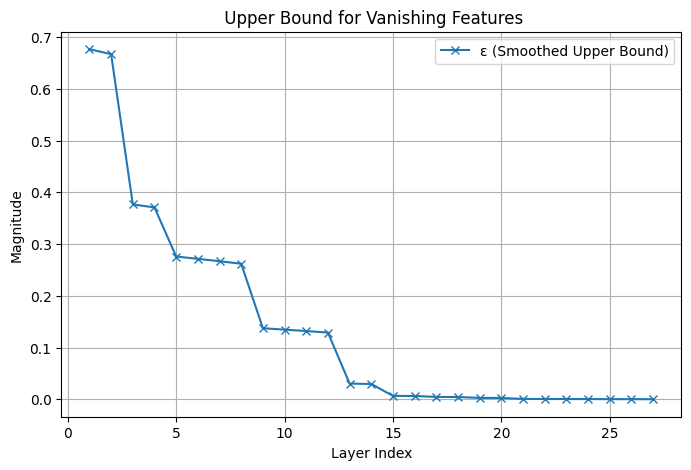

[2024-12-14 10:54:43] (24096) {logger.py:58}INFO - Model: cifar_resnet20
[2024-12-14 10:54:43] (24096) {logger.py:58}INFO - Seed: [30, 30, 10, 10]


Files already downloaded and verified
Files already downloaded and verified


[2024-12-14 10:54:44] (24096) {utils.py:69}INFO - Test: [ 1/40]	Time  0.030 ( 0.030)	Loss 1.8701e-01 (1.8701e-01)	Acc@1  94.14 ( 94.14)	Acc@5 100.00 (100.00)
[2024-12-14 10:54:45] (24096) {utils.py:74}INFO -  *   Acc@1 92.000 Acc@5 99.680


Calculating activations for zero input
Calculating means
Calculating stds
Calculating activations for zero input
Calculating means
Calculating stds
Calculating activations for zero input
Calculating means
Calculating stds


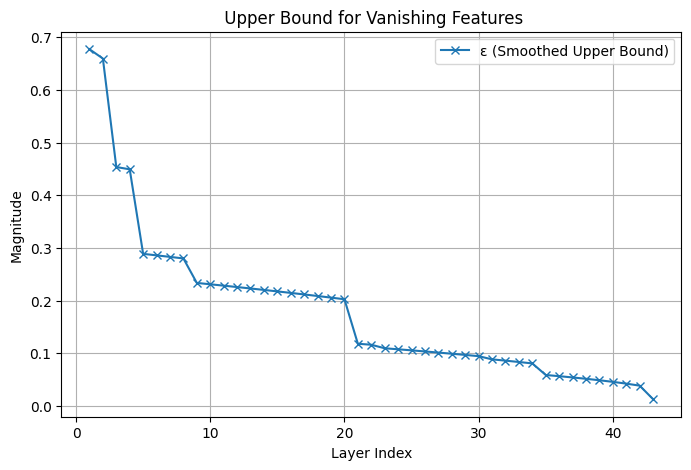

[2024-12-14 10:54:49] (24096) {logger.py:58}INFO - Model: cifar_resnet20_ln
[2024-12-14 10:54:49] (24096) {logger.py:58}INFO - Seed: [30, 30, 10, 10]


Files already downloaded and verified
Files already downloaded and verified


[2024-12-14 10:54:50] (24096) {utils.py:69}INFO - Test: [ 1/40]	Time  0.043 ( 0.043)	Loss 2.8987e-01 (2.8987e-01)	Acc@1  89.84 ( 89.84)	Acc@5 100.00 (100.00)
[2024-12-14 10:54:52] (24096) {utils.py:74}INFO -  *   Acc@1 89.550 Acc@5 99.630


Calculating activations for zero input
Calculating means
Calculating stds
Calculating activations for zero input
Calculating means
Calculating stds
Calculating activations for zero input
Calculating means
Calculating stds


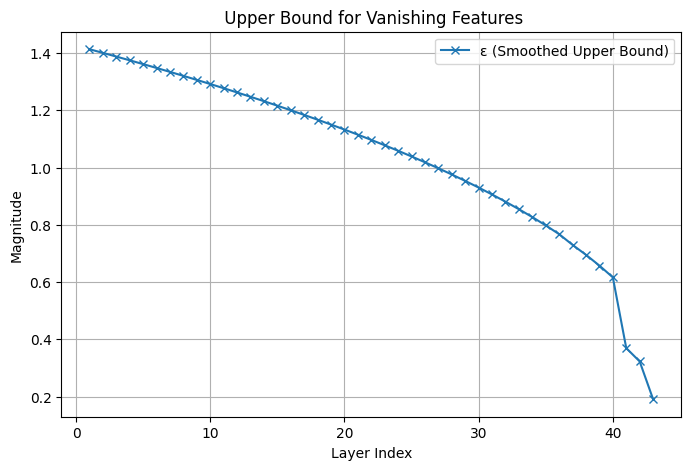

In [29]:
for model_name, seed in zip(model_name_s, seed_s):
    logger.info(f"Model: {model_name}")
    logger.info(f"Seed: {seed_s}")
    
    class config:
        model = model_name
        dataset = 'cifar10'
        print_freq = 100
        path = '../data' # path to dataset
        special_init = 'vgg_init'
    # prepare data
    trainset, testset = load_data(config.path, config.dataset, no_random_aug=True)
    trainloader = DataLoader(trainset, batch_size=128, shuffle=False, drop_last=True) # set shuffle=False, drop_last=True, so we have correct estimates of the mean and std
    testloader = DataLoader(testset, batch_size=256, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    # prepare edge models
    sd_1 = torch.load(f'../ex_results/same_init_ex/cifar10/{config.model}/diff_init/seed_{seed}/model_1_160.pt', map_location=device, weights_only=True)
    sd_2 = torch.load(f'../ex_results/same_init_ex/cifar10/{config.model}/diff_init/seed_{seed}/model_2_160.pt', map_location=device, weights_only=True)
    model_1 = load_model(config, 3).to(device)
    model_2 = load_model(config, 3).to(device)
    model_1.load_state_dict(sd_1)
    model_2.load_state_dict(sd_2)
    validate(testloader, model_1, criterion, device, config)
    # obtain the merged midpoint model
    sd_mid = interpolate_state_dicts(sd_1, sd_2, 0.5)
    model_mid = deepcopy(model_1)
    model_mid.load_state_dict(sd_mid)
    
    # record activations
    act_metric = 'diff'
    mean_metric = 'l2_mean'
    pre_relu=False

    model_test = deepcopy(model_mid)
    means_dict, stds_dict, zero_act_dict = record_activations(model_test, testloader, mean_metric, act_metric, pre_relu=pre_relu)
    layer_average_mean_scales_dict = {}
    layer_average_stds_dict = {}
    for name in means_dict:
        layer_average_mean_scales_dict[name] = np.mean(np.abs(means_dict[name]))
        layer_average_stds_dict[name] = np.mean(stds_dict[name])
    layer_average_mean_scales_dict_array = np.array(list(layer_average_mean_scales_dict.values()))
    layer_average_stds_dict_array = np.array(list(layer_average_stds_dict.values()))
    ## model 1
    model_base_1 = deepcopy(model_1)
    means_dict_1, stds_dict_1, zero_act_dict_1 = record_activations(model_base_1, testloader, mean_metric, act_metric, pre_relu=pre_relu)
    layer_average_mean_scales_dict_1 = {}
    layer_average_stds_dict_1 = {}
    for name in means_dict_1:
        layer_average_mean_scales_dict_1[name] = np.mean(np.abs(means_dict_1[name]))
        layer_average_stds_dict_1[name] = np.mean(stds_dict_1[name])
    layer_average_mean_scales_dict_array_1 = np.array(list(layer_average_mean_scales_dict_1.values()))
    layer_average_stds_dict_array_1 = np.array(list(layer_average_stds_dict_1.values()))
    ## model 2
    model_base_2 = deepcopy(model_2)
    means_dict_2, stds_dict_2, zero_act_dict_2 = record_activations(model_base_2, testloader, mean_metric, act_metric, pre_relu=pre_relu)
    layer_average_mean_scales_dict_2 = {}
    layer_average_stds_dict_2 = {}
    for name in means_dict_2:
        layer_average_mean_scales_dict_2[name] = np.mean(np.abs(means_dict_2[name]))
        layer_average_stds_dict_2[name] = np.mean(stds_dict_2[name])
    layer_average_mean_scales_dict_array_2 = np.array(list(layer_average_mean_scales_dict_2.values()))
    layer_average_stds_dict_array_2 = np.array(list(layer_average_stds_dict_2.values()))
    res_dict = {"means_dict": layer_average_mean_scales_dict, "stds_dict": layer_average_stds_dict, 'means_arr': layer_average_mean_scales_dict_array, 'stds_arr': layer_average_stds_dict_array,
                "means_dict_1": layer_average_mean_scales_dict_1, "stds_dict_1": layer_average_stds_dict_1, 'means_arr_1': layer_average_mean_scales_dict_array_1, 'stds_arr_1': layer_average_stds_dict_array_1,
                "means_dict_2": layer_average_mean_scales_dict_2, "stds_dict_2": layer_average_stds_dict_2, 'means_arr_2': layer_average_mean_scales_dict_array_2, 'stds_arr_2': layer_average_stds_dict_array_2}
    mean_mid_arr = res_dict['means_arr']
    mean_1_arr =  res_dict['means_arr_1']
    mean_2_arr = res_dict['means_arr_2']

    normalized_mean_arr = mean_mid_arr / (mean_1_arr + mean_2_arr) * 2
    res_dict.update({'normalized_mean_arr': normalized_mean_arr})
    
    # caulculate the upper bound sequence
    E_arr = normalized_mean_arr

    epsilon_arr = np.zeros_like(E_arr)
    alpha = 1.4  # Smoothing factor
    L = len(E_arr)
    epsilon_arr[-1] = E_arr[-1]  # Start with the last value

    for i in range(len(E_arr) - 2, -1, -1):
        smooth_value = alpha * epsilon_arr[i + 1] + (1 - alpha) * epsilon_arr[i + 1] * (1 - 1 / (L - i + 1))
        epsilon_arr[i] = max(E_arr[i], smooth_value)

    res_dict.update({'epsilon_arr': epsilon_arr})

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(E_arr) + 1), epsilon_arr, label='ε (Smoothed Upper Bound)', marker='x')
    plt.xlabel('Layer Index')
    plt.ylabel('Magnitude')
    plt.title(' Upper Bound for Vanishing Features')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # save the results
    save_dir = 'CPAL_plots/vf_general'
    os.makedirs(save_dir, exist_ok=True)
    prefix = config.dataset + '_' + config.model

    save_name = f'{save_dir}/{prefix}_res_dict.pth'
    if os.path.exists(save_name):
        raise ValueError(f"File {save_name} already exists")
    else:
        torch.save(res_dict, save_name)

### Visualize the upper bound for vanishing feature

In [30]:
save_template = 'CPAL_plots/vf_general/cifar10_cifar_{}_res_dict.pth'
vgg16_res_dict = torch.load(save_template.format('vgg16'))
vgg16_bn_res_dict = torch.load(save_template.format('vgg16_bn'))
resnet20_res_dict = torch.load(save_template.format('resnet20'))
resnet20_ln_res_dict = torch.load(save_template.format('resnet20_ln'))

vgg16_epsilon_arr = vgg16_res_dict['epsilon_arr']
vgg16_bn_epsilon_arr = vgg16_bn_res_dict['epsilon_arr']
resnet20_epsilon__arr = resnet20_res_dict['epsilon_arr']
resnet20_ln_epsilon_arr = resnet20_ln_res_dict['epsilon_arr']

C:\Users\jessogreat\AppData\Local\Temp\ipykernel_24096\1371408706.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg16_res_dict = torch.load(save_template.format('vgg16

[2024-12-14 10:55:22] (24096) {_mathtext.py:648}INFO - Substituting symbol D from STIXNonUnicode
[2024-12-14 10:55:22] (24096) {_mathtext.py:648}INFO - Substituting symbol D from STIXNonUnicode
[2024-12-14 10:55:22] (24096) {_mathtext.py:648}INFO - Substituting symbol D from STIXNonUnicode
[2024-12-14 10:55:22] (24096) {_mathtext.py:648}INFO - Substituting symbol D from STIXNonUnicode


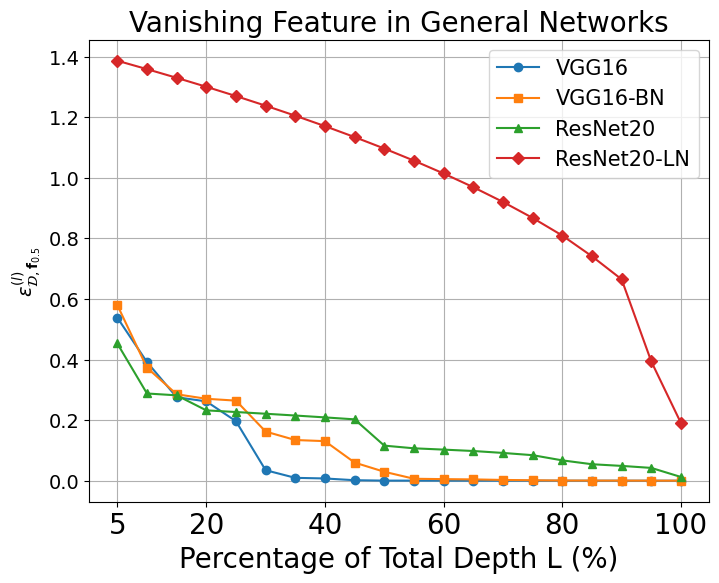

In [31]:
intervals = np.linspace(0.05, 1, 20)  # 10% intervals
vgg16_layers = np.arange(len(vgg16_epsilon_arr))
vgg16_bn_layers = np.arange(len(vgg16_bn_epsilon_arr))
resnet20_layers = np.arange(len(resnet20_epsilon__arr))

vgg16_interp = np.interp(intervals, vgg16_layers / max(vgg16_layers), vgg16_epsilon_arr)
vgg16_bn_interp = np.interp(intervals, vgg16_bn_layers / max(vgg16_bn_layers), vgg16_bn_epsilon_arr)
resnet20_interp = np.interp(intervals, resnet20_layers / max(resnet20_layers), resnet20_epsilon__arr)
resnet20_ln_interp = np.interp(intervals, resnet20_layers / max(resnet20_layers), resnet20_ln_epsilon_arr)


plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})
plt.plot(intervals * 100, vgg16_interp, label='VGG16', marker='o')
plt.plot(intervals * 100, vgg16_bn_interp, label='VGG16-BN', marker='s')
plt.plot(intervals * 100, resnet20_interp, label='ResNet20', marker='^')
plt.plot(intervals * 100, resnet20_ln_interp, label='ResNet20-LN', marker='D')

plt.xlabel('Percentage of Total Depth L (%)', fontsize=20)
xticks = [5, 20, 40, 60, 80, 100]
plt.xticks(xticks, fontsize=20)
plt.ylabel(r'$\varepsilon_{\mathcal{D},\mathbf{f}_{0.5}}^{(l)}$')
plt.title('Vanishing Feature in General Networks', fontsize=20)
plt.legend(fontsize=15)
plt.grid(True)

### visualize last layer output

In [8]:
model_name = 'cifar_resnet20'
seed = 10

class config:
    model = model_name
    dataset = 'cifar10'
    print_freq = 100
    path = '../data' # path to dataset
    special_init = 'vgg_init'
# prepare data
trainset, testset = load_data(config.path, config.dataset, no_random_aug=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=False, drop_last=True) # set shuffle=False, drop_last=True, so we have correct estimates of the mean and std
testloader = DataLoader(testset, batch_size=512, shuffle=False)
criterion = nn.CrossEntropyLoss()
# prepare edge models
sd_1 = torch.load(f'../ex_results/same_init_ex/cifar10/{config.model}/diff_init/seed_{seed}/model_1_160.pt', map_location=device, weights_only=True)
sd_2 = torch.load(f'../ex_results/same_init_ex/cifar10/{config.model}/diff_init/seed_{seed}/model_2_160.pt', map_location=device, weights_only=True)
model_1 = load_model(config, 3).to(device)
model_2 = load_model(config, 3).to(device)
model_1.load_state_dict(sd_1)
model_2.load_state_dict(sd_2)
validate(testloader, model_1, criterion, device, config)
# obtain the merged midpoint model
sd_mid = interpolate_state_dicts(sd_1, sd_2, 0.5)
model_mid = deepcopy(model_1)
model_mid.load_state_dict(sd_mid)

Files already downloaded and verified
Files already downloaded and verified


[2024-12-14 11:07:05] (1480) {utils.py:69}INFO - Test: [ 1/20]	Time  0.064 ( 0.064)	Loss 2.3211e-01 (2.3211e-01)	Acc@1  93.36 ( 93.36)	Acc@5 100.00 (100.00)
[2024-12-14 11:07:07] (1480) {utils.py:74}INFO -  *   Acc@1 92.000 Acc@5 99.680


<All keys matched successfully>

In [10]:
zero_input = torch.zeros((1, 3, 32, 32)).to(device)

model_test = deepcopy(model_mid)
model_test.eval()

# calculate mean of the output of the model
total = 10000
batch_means = torch.zeros(10).to(device)
for images, _ in testloader:
    images = images.to(device)
    with torch.no_grad():
        out = model_test(images)
    batch_means += out.sum(0) / total
# calculate the std
batch_vars = torch.zeros(10).to(device)
for images, _ in testloader:
    images = images.to(device)
    with torch.no_grad():
        out = model_test(images)
    batch_vars += ((out - batch_means) ** 2).sum(0) / total
batch_stds = torch.sqrt(batch_vars)
# calculate zero out
zero_out = model_test(zero_input).detach().to('cpu')
# calculate baseline mean
baseline_mean_1 = torch.zeros(10).to(device)
baseline_mean_2 = torch.zeros(10).to(device)
for images, _ in testloader:
    images = images.to(device)
    with torch.no_grad():
        out_1 = model_1(images)
        out_2 = model_2(images)
    baseline_mean_1 += out_1.sum(0) / total
    baseline_mean_2 += out_2.sum(0) / total
# calculate baseline std
baseline_var_1 = torch.zeros(10).to(device)
baseline_var_2 = torch.zeros(10).to(device)
for images, _ in testloader:
    images = images.to(device)
    with torch.no_grad():
        out_1 = model_1(images)
        out_2 = model_2(images)
    baseline_var_1 += ((out - baseline_mean_1) ** 2).sum(0) / total
    baseline_var_2 += ((out - baseline_mean_2) ** 2).sum(0) / total
baseline_std_1 = torch.sqrt(baseline_var_1)
baseline_std_2 = torch.sqrt(baseline_var_2)

baseline_means = (baseline_mean_1 + baseline_mean_2) / 2
baseline_stds = (baseline_std_1 + baseline_std_2) / 2
batch_means = batch_means.to('cpu').numpy()
batch_stds = batch_stds.to('cpu').numpy()
baseline_means = baseline_means.to('cpu').numpy()
baseline_stds = baseline_stds.to('cpu').numpy()

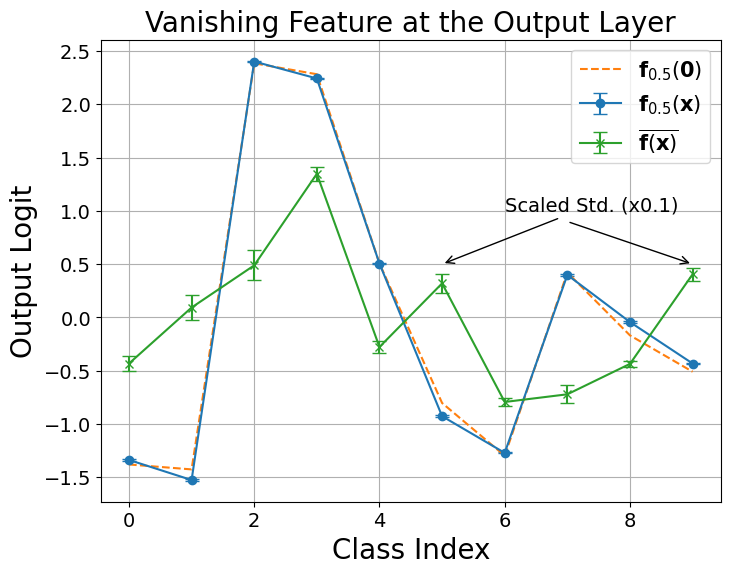

In [12]:
normalized_batch_stds = batch_stds / 10
normalized_baseline_stds = baseline_stds / 10

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

plt.errorbar(range(len(batch_means)), batch_means, yerr=normalized_batch_stds, fmt='o', label=r'$\mathbf{f}_{0.5}(\mathbf{x})$', capsize=5, linestyle='-')
plt.plot(zero_out[0], label=r'$\mathbf{f}_{0.5}(\mathbf{0})$', linestyle='--')

plt.errorbar(range(len(baseline_means)), baseline_means, yerr=normalized_baseline_stds, fmt='x', label=r'$\overline{\mathbf{f}(\mathbf{x})}$', capsize=5, linestyle='-')

arrow_x, arrow_y = 5, 0.5
plt.annotate(
    'Scaled Std. (x0.1)',        
    xy=(arrow_x, arrow_y),          
    xytext=(6, 1),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=14
)
plt.annotate(
    '',          
    xy=(9, 0.5),              
    xytext=(7, 0.9), 
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=14
)

plt.xlabel('Class Index', fontsize=20)
plt.ylabel('Output Logit', fontsize=20)
plt.title('Vanishing Feature at the Output Layer', fontsize=20)
plt.legend(fontsize=15)
plt.grid(True)

## VF in pruned model

Files already downloaded and verified
Files already downloaded and verified


[2024-12-14 11:21:58] (1480) {utils.py:69}INFO - Test: [ 1/20]	Time  0.073 ( 0.073)	Loss 2.5603e-01 (2.5603e-01)	Acc@1  94.34 ( 94.34)	Acc@5  99.80 ( 99.80)
[2024-12-14 11:21:59] (1480) {utils.py:74}INFO -  *   Acc@1 93.460 Acc@5 99.610
[2024-12-14 11:21:59] (1480) {utils.py:69}INFO - Test: [ 1/20]	Time  0.074 ( 0.074)	Loss 2.1162e+00 (2.1162e+00)	Acc@1  22.46 ( 22.46)	Acc@5  72.27 ( 72.27)
[2024-12-14 11:22:00] (1480) {utils.py:74}INFO -  *   Acc@1 23.570 Acc@5 72.120
[2024-12-14 11:22:12] (1480) {utils.py:69}INFO - Test: [ 1/20]	Time  0.066 ( 0.066)	Loss 2.7747e-01 (2.7747e-01)	Acc@1  92.19 ( 92.19)	Acc@5  99.61 ( 99.61)
[2024-12-14 11:22:13] (1480) {utils.py:74}INFO -  *   Acc@1 92.020 Acc@5 99.290


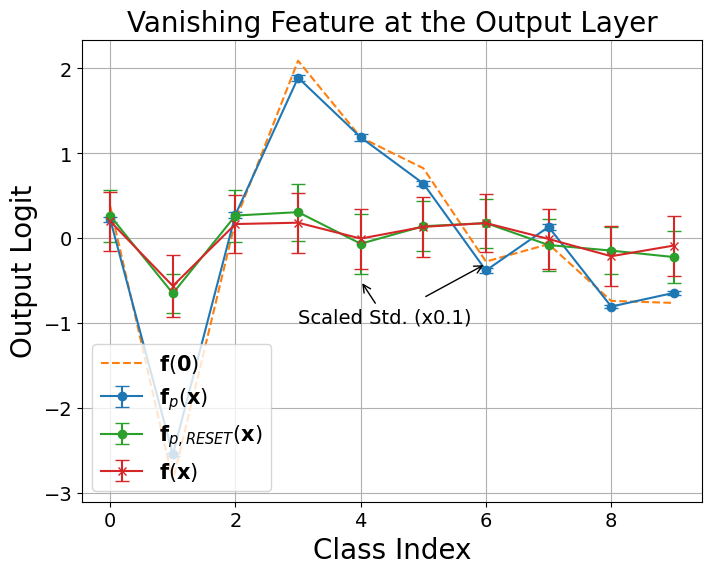

Calculating activations for zero input
Calculating means
Calculating stds
Calculating activations for zero input
Calculating means
Calculating stds
Calculating activations for zero input
Calculating means
Calculating stds
Files already downloaded and verified
Files already downloaded and verified


[2024-12-14 11:22:26] (1480) {utils.py:69}INFO - Test: [ 1/20]	Time  0.061 ( 0.061)	Loss 2.3211e-01 (2.3211e-01)	Acc@1  93.36 ( 93.36)	Acc@5 100.00 (100.00)
[2024-12-14 11:22:27] (1480) {utils.py:74}INFO -  *   Acc@1 92.000 Acc@5 99.680
[2024-12-14 11:22:28] (1480) {utils.py:69}INFO - Test: [ 1/20]	Time  0.058 ( 0.058)	Loss 5.8785e+00 (5.8785e+00)	Acc@1   9.57 (  9.57)	Acc@5  64.65 ( 64.65)
[2024-12-14 11:22:29] (1480) {utils.py:74}INFO -  *   Acc@1 10.590 Acc@5 66.330


Calculating activations for zero input
Calculating means
Calculating stds
Calculating activations for zero input
Calculating means
Calculating stds
Calculating activations for zero input
Calculating means
Calculating stds


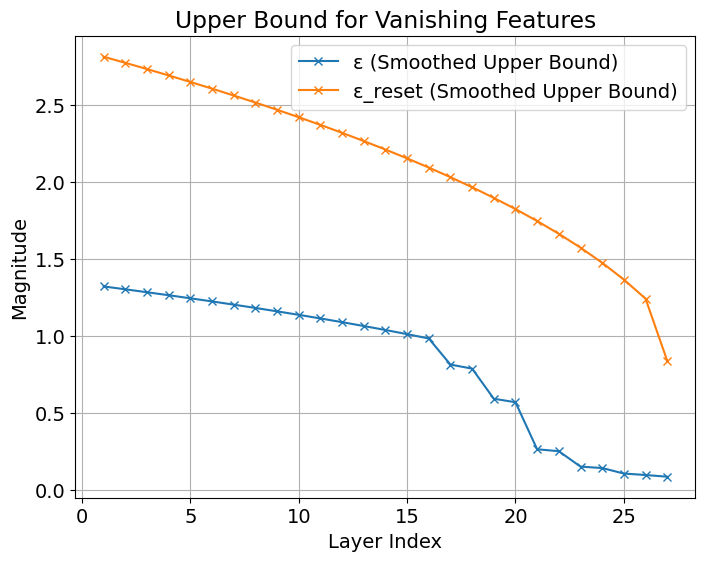

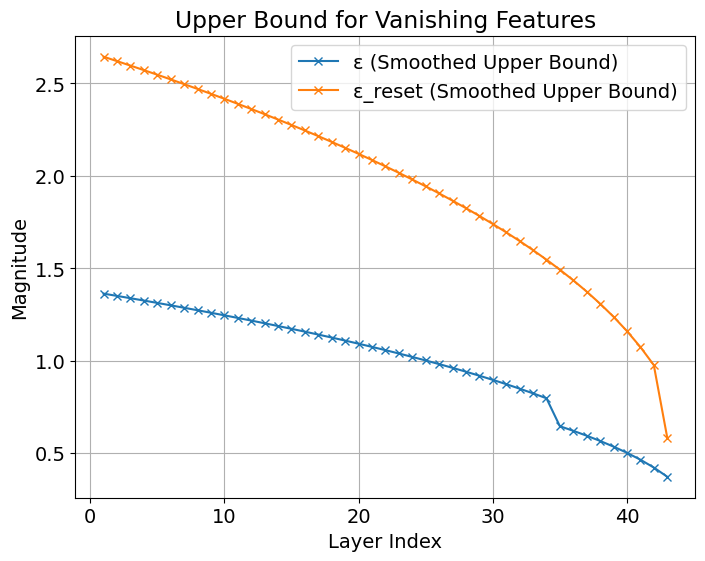

In [ ]:
import torch.nn.utils.prune as prune

model_name_s = ['cifar_vgg16_bn', 'cifar_resnet20']
seed_s = [10, 10]
sparsity_s = [0.8, 0.85]

for model_name, seed, sparsity in zip(model_name_s, seed_s, sparsity_s):

    class config:
        model = model_name
        dataset = 'cifar10'
        print_freq = 100
        path = '../data' # path to dataset
        special_init = 'vgg_init'
    # prepare data
    trainset, testset = load_data(config.path, config.dataset, no_random_aug=True)
    trainloader = DataLoader(trainset, batch_size=128, shuffle=False, drop_last=True) # set shuffle=False, drop_last=True, so we have correct estimates of the mean and std
    testloader = DataLoader(testset, batch_size=512, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    # prepare edge models
    sd_1 = torch.load(f'../ex_results/same_init_ex/cifar10/{config.model}/diff_init/seed_{seed}/model_1_160.pt', map_location=device, weights_only=True)
    sd_2 = torch.load(f'../ex_results/same_init_ex/cifar10/{config.model}/diff_init/seed_{seed}/model_2_160.pt', map_location=device, weights_only=True)
    model_1 = load_model(config, 3).to(device)
    model_2 = load_model(config, 3).to(device)
    model_1.load_state_dict(sd_1)
    model_2.load_state_dict(sd_2)
    validate(testloader, model_1, criterion, device, config)
    # obtain the merged midpoint model
    sd_mid = interpolate_state_dicts(sd_1, sd_2, 0.5)
    model_mid = deepcopy(model_1)
    model_mid.load_state_dict(sd_mid)
    
    # pruning
    amount = sparsity
    model_1_global_pruned = deepcopy(model_2)
    parameters_pruned = []
    # prune the weights in all linear and convolutional layers
    for name, module in model_1_global_pruned.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            parameters_pruned.append((module, 'weight'))
    parameters_pruned = tuple(parameters_pruned)
    prune.global_unstructured(parameters_pruned, pruning_method=prune.L1Unstructured, amount=amount)
    for param, name in parameters_pruned:
        prune.remove(param, name)
    validate(testloader, model_1_global_pruned, criterion, device, config)
    
    # record activations
    if model_name == 'cifar_vgg16_bn':
        # last layer output
        zero_input = torch.zeros((1, 3, 32, 32)).to(device)

        model_test = deepcopy(model_1_global_pruned)
        model_baseline = model_2

        model_test.eval()

        # calculate mean of the output of the model
        total = 10000
        batch_means = torch.zeros(10).to(device)
        for images, _ in testloader:
            images = images.to(device)
            with torch.no_grad():
                out = model_test(images)
            batch_means += out.sum(0) / total
        # calculate the std
        batch_vars = torch.zeros(10).to(device)
        for images, _ in testloader:
            images = images.to(device)
            with torch.no_grad():
                out = model_test(images)
            batch_vars += ((out - batch_means) ** 2).sum(0) / total
        batch_stds = torch.sqrt(batch_vars)
        # calculate zero out
        zero_out = model_test(zero_input).detach().to('cpu')
        # reset
        reset_bn_stats(model_test, device, trainloader)
        model_test.eval()
        # calculate reset mean
        reset_means = torch.zeros(10).to(device)
        for images, _ in testloader:
            images = images.to(device)
            with torch.no_grad():
                out = model_test(images)
            reset_means += out.sum(0) / total
        # calculate reset std
        reset_vars = torch.zeros(10).to(device)
        for images, _ in testloader:
            images = images.to(device)
            with torch.no_grad():
                out = model_test(images)
            reset_vars += ((out - reset_means) ** 2).sum(0) / total
        reset_stds = torch.sqrt(reset_vars)
        validate(testloader, model_test, criterion, device, config)
        # calculate baseline mean
        baseline_means = torch.zeros(10).to(device)
        for images, _ in testloader:
            images = images.to(device)
            with torch.no_grad():
                out = model_baseline(images)
            baseline_means += out.sum(0) / total
        # calculate baseline std
        baseline_vars = torch.zeros(10).to(device)
        for images, _ in testloader:
            images = images.to(device)
            with torch.no_grad():
                out = model_baseline(images)
            baseline_vars += ((out - baseline_means) ** 2).sum(0) / total
        baseline_stds = torch.sqrt(baseline_vars)
        batch_means = batch_means.to('cpu').numpy()
        batch_stds = batch_stds.to('cpu').numpy()
        reset_means = reset_means.to('cpu').numpy()
        reset_stds = reset_stds.to('cpu').numpy()
        baseline_means = baseline_means.to('cpu').numpy()
        baseline_stds = baseline_stds.to('cpu').numpy()
        
        # visualize the results
        normalized_batch_stds = batch_stds / 10
        normalized_reset_stds = reset_stds / 10
        normalized_baseline_stds = baseline_stds / 10
        plt.figure(figsize=(8, 6))
        plt.rcParams.update({'font.size': 14})
        plt.errorbar(range(len(batch_means)), batch_means, yerr=normalized_batch_stds, fmt='o', label=r'$\mathbf{f}_{p}(\mathbf{x})$', capsize=5, linestyle='-')
        plt.plot(zero_out[0], label=r'$\mathbf{f}(\mathbf{0})$', linestyle='--')
        plt.errorbar(range(len(reset_means)), reset_means, yerr=normalized_reset_stds, fmt='o', label=r'$\mathbf{f}_{p, RESET}(\mathbf{x})$', capsize=5, linestyle='-')
        plt.errorbar(range(len(baseline_means)), baseline_means, yerr=normalized_baseline_stds, fmt='x', label=r'$\mathbf{f}(\mathbf{x})$', capsize=5, linestyle='-')
        if config.model == 'cifar_vgg16_bn':
            plot_pionts = [(4, -0.5), (3, -1), (6, -0.3), (5, -0.7)]
        elif config.model == 'cifar_resnet20':
            plot_pionts = [(2, -0.2), (3, -3), (4.8, -0.3), (4, -2.5)]

        arrow_x, arrow_y = 4, -0.5
        plt.annotate(
            'Scaled Std. (x0.1)',           
            xy=plot_pionts[0],             
            xytext=plot_pionts[1],
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=14
        )
        plt.annotate(
            '',            
            xy=plot_pionts[2],              
            xytext=plot_pionts[3],
            arrowprops=dict(facecolor='black', arrowstyle='->'), 
            fontsize=14
        )
        plt.xlabel('Class Index', fontsize=20)
        plt.ylabel('Output Logit', fontsize=20)
        plt.title('Vanishing Feature at the Output Layer', fontsize=20)
        plt.legend(fontsize=15, loc='lower left')
        plt.grid(True)
        plt.show()
    
    # recorde intermediate layer
    act_metric = 'diff'
    mean_metric = 'l2_mean'
    pre_relu=False
    model_test = deepcopy(model_1_global_pruned)
    model_base = model_2
    means_dict, stds_dict, zero_act_dict = record_activations(model_test, testloader, mean_metric, act_metric, pre_relu=pre_relu)
    layer_average_mean_scales_dict = {}
    layer_average_stds_dict = {}
    for name in means_dict:
        layer_average_mean_scales_dict[name] = np.mean(np.abs(means_dict[name]))
        layer_average_stds_dict[name] = np.mean(stds_dict[name])
    layer_average_mean_scales_dict_array = np.array(list(layer_average_mean_scales_dict.values()))
    layer_average_stds_dict_array = np.array(list(layer_average_stds_dict.values()))
    ## reset model
    reset_bn_stats(model_test, device, trainloader)
    means_dict_reset, stds_dict_reset, zero_act_dict_reset = record_activations(model_test, testloader, mean_metric, act_metric, pre_relu=pre_relu)
    layer_average_mean_scales_dict_reset = {}
    layer_average_stds_dict_reset = {}
    for name in means_dict_reset:
        layer_average_mean_scales_dict_reset[name] = np.mean(np.abs(means_dict_reset[name]))
        layer_average_stds_dict_reset[name] = np.mean(stds_dict_reset[name])
    layer_average_mean_scales_dict_array_reset = np.array(list(layer_average_mean_scales_dict_reset.values()))
    layer_average_stds_dict_array_reset = np.array(list(layer_average_stds_dict_reset.values()))
    ## baseline model
    means_dict_base, stds_dict_base, zero_act_dict_base = record_activations(model_base, testloader, mean_metric, act_metric, pre_relu=pre_relu)
    layer_average_mean_scales_dict_base = {}
    layer_average_stds_dict_base = {}
    for name in means_dict_base:
        layer_average_mean_scales_dict_base[name] = np.mean(np.abs(means_dict_base[name]))
        layer_average_stds_dict_base[name] = np.mean(stds_dict_base[name])
    layer_average_mean_scales_dict_array_base = np.array(list(layer_average_mean_scales_dict_base.values()))
    layer_average_stds_dict_array_base = np.array(list(layer_average_stds_dict_base.values()))
    res_dict = {"means_dict": layer_average_mean_scales_dict, "stds_dict": layer_average_stds_dict, 'means_arr': layer_average_mean_scales_dict_array, 'stds_arr': layer_average_stds_dict_array,
                "means_dict_reset": layer_average_mean_scales_dict_reset, "stds_dict_reset": layer_average_stds_dict_reset, 'means_arr_reset': layer_average_mean_scales_dict_array_reset, 'stds_arr_reset': layer_average_stds_dict_array_reset,
                "means_dict_base": layer_average_mean_scales_dict_base, "stds_dict_base": layer_average_stds_dict_base, 'means_arr_base': layer_average_mean_scales_dict_array_base, 'stds_arr_base': layer_average_stds_dict_array_base}
    mean_mid_arr = res_dict['means_arr']
    mean_reset_arr =  res_dict['means_arr_reset']
    mean_base_arr = res_dict['means_arr_base']
    normalized_mean_arr = mean_mid_arr / mean_base_arr
    nomalized_reset_mean_arr = mean_reset_arr / mean_base_arr
    res_dict.update({'normalized_mean_arr': normalized_mean_arr, 'nomalized_reset_mean_arr': nomalized_reset_mean_arr})

    # record and visualize the upper bound
    E_arr = normalized_mean_arr
    E_reset_arr = nomalized_reset_mean_arr
    epsilon_arr = np.zeros_like(E_arr)
    epsilon_reset_arr = np.zeros_like(E_reset_arr)
    alpha = 1.4  # Smoothing factor
    L = len(E_arr)
    epsilon_arr[-1] = E_arr[-1]  # Start with the last value
    epsilon_reset_arr[-1] = E_reset_arr[-1]  # Start with the last value
    for i in range(len(E_arr) - 2, -1, -1):
        smooth_value = alpha * epsilon_arr[i + 1] + (1 - alpha) * epsilon_arr[i + 1] * (1 - 1 / (L - i + 1))
        epsilon_arr[i] = max(E_arr[i], smooth_value)
        smooth_value = alpha * epsilon_reset_arr[i + 1] + (1 - alpha) * epsilon_reset_arr[i + 1] * (1 - 1 / (L - i + 1))
        epsilon_reset_arr[i] = max(E_reset_arr[i], smooth_value)

    res_dict.update({'epsilon_arr': epsilon_arr, 'epsilon_reset_arr': epsilon_reset_arr})
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(E_arr) + 1), epsilon_arr, label='ε (Smoothed Upper Bound)', marker='x')
    plt.plot(range(1, len(E_reset_arr) + 1), epsilon_reset_arr, label='ε_reset (Smoothed Upper Bound)', marker='x')
    plt.xlabel('Layer Index')
    plt.ylabel('Magnitude')
    plt.title('Upper Bound for Vanishing Features')
    plt.legend()
    plt.grid(True)
    
    # save the results
    save_dir = 'CPAL_plots/pruned_vf'
    os.makedirs(save_dir, exist_ok=True)
    prefix = config.dataset + '_' + config.model
    save_name = f'{save_dir}/pruned_{prefix}_res_dict.pth'
    if os.path.exists(save_name):
        raise ValueError(f"File {save_name} already exists")
    else:
        torch.save(res_dict, save_name)

### Summary

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt

save_template = 'CPAL_plots/pruned_vf/pruned_cifar10_cifar_{}_res_dict.pth'
vgg16_bn_res_dict = torch.load(save_template.format('vgg16_bn'))
resnet20_res_dict = torch.load(save_template.format('resnet20'))

vgg16_bn_epsilon_arr = vgg16_bn_res_dict['epsilon_arr']
vgg16_bn_reset_epsilon_arr = vgg16_bn_res_dict['epsilon_reset_arr']
resnet20_epsilon__arr = resnet20_res_dict['epsilon_arr']
resnet20_reset_epsilon_arr = resnet20_res_dict['epsilon_reset_arr']

C:\Users\jessogreat\AppData\Local\Temp\ipykernel_1480\1519255798.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg16_bn_res_dict = torch.load(save_template.format('vgg

[2024-12-14 11:22:44] (1480) {_mathtext.py:648}INFO - Substituting symbol D from STIXNonUnicode
[2024-12-14 11:22:44] (1480) {_mathtext.py:648}INFO - Substituting symbol D from STIXNonUnicode
[2024-12-14 11:22:44] (1480) {_mathtext.py:648}INFO - Substituting symbol D from STIXNonUnicode
[2024-12-14 11:22:44] (1480) {_mathtext.py:648}INFO - Substituting symbol D from STIXNonUnicode


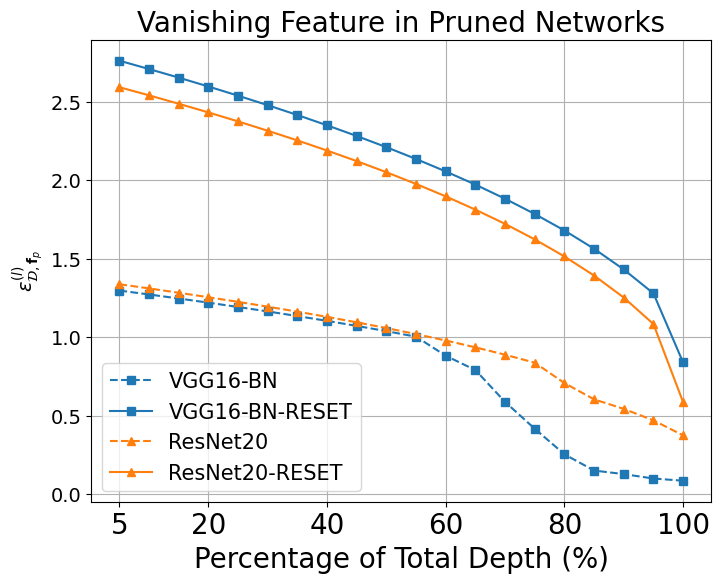

In [ ]:
intervals = np.linspace(0.05, 1, 20)  # 10% intervals
vgg16_bn_layers = np.arange(len(vgg16_bn_epsilon_arr))
resnet20_layers = np.arange(len(resnet20_epsilon__arr))
vgg16_bn_interp = np.interp(intervals, vgg16_bn_layers / max(vgg16_bn_layers), vgg16_bn_epsilon_arr)
vgg16_bn_reset_interp = np.interp(intervals, vgg16_bn_layers / max(vgg16_bn_layers), vgg16_bn_reset_epsilon_arr)
resnet20_interp = np.interp(intervals, resnet20_layers / max(resnet20_layers), resnet20_epsilon__arr)
resnet20_reset_interp = np.interp(intervals, resnet20_layers / max(resnet20_layers), resnet20_reset_epsilon_arr)

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})
plt.plot(intervals * 100, vgg16_bn_interp, label='VGG16-BN', marker='s', linestyle='--', color='tab:blue')
plt.plot(intervals * 100, vgg16_bn_reset_interp, label='VGG16-BN-RESET', marker='s', color='tab:blue')
plt.plot(intervals * 100, resnet20_interp, label='ResNet20', marker='^', linestyle='--', color='tab:orange')
plt.plot(intervals * 100, resnet20_reset_interp, label='ResNet20-RESET', marker='^', color='tab:orange')
plt.xlabel('Percentage of Total Depth (%)', fontsize=20)
xticks = [5, 20, 40, 60, 80, 100]
plt.xticks(xticks, fontsize=20)
plt.ylabel(r'$\varepsilon_{\mathcal{D},\mathbf{f}_{p}}^{(l)}$')
plt.title('Vanishing Feature in Pruned Networks', fontsize=20)
plt.legend(fontsize=15)
plt.grid(True)